In [23]:
import pandas as pd
import numpy as np

energy_met=pd.read_csv('energy_states_consolidated.csv')
max_demand=pd.read_csv('max_states_consolidated.csv')

# Convert the 'Date' column to datetime format
energy_met['Date'] = pd.to_datetime(energy_met['Date'],format='%d-%m-%y')
max_demand['Date'] = pd.to_datetime(max_demand['Date'],format='%d-%m-%y')

#Setting the Date column as the index
energy_met.set_index('Date', inplace=True)
max_demand.set_index('Date', inplace=True)

energy_met.sort_index(inplace=True)
max_demand.sort_index(inplace=True)


# Handle missing values (e.g., forward fill)
energy_met.fillna(method='ffill', inplace=True)
max_demand.fillna(method='ffill', inplace=True)

/var/folders/x5/67k0hq3s7rq6zj38gkfh19m00000gn/T/ipykernel_31235/454178655.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  energy_met.fillna(method='ffill', inplace=True)
/var/folders/x5/67k0hq3s7rq6zj38gkfh19m00000gn/T/ipykernel_31235/454178655.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  max_demand.fillna(method='ffill', inplace=True)


In [24]:
state='Karnataka'
df=pd.DataFrame(energy_met[state])
df.head()

,Karnataka
Date,
2020-01-01,212.2
2020-01-02,205.3
2020-01-03,212.4
2020-01-04,217.5
2020-01-05,217.4


In [25]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3, test_size=365*1, gap=1)
df = df.sort_index()

In [26]:
import matplotlib.pyplot as plt

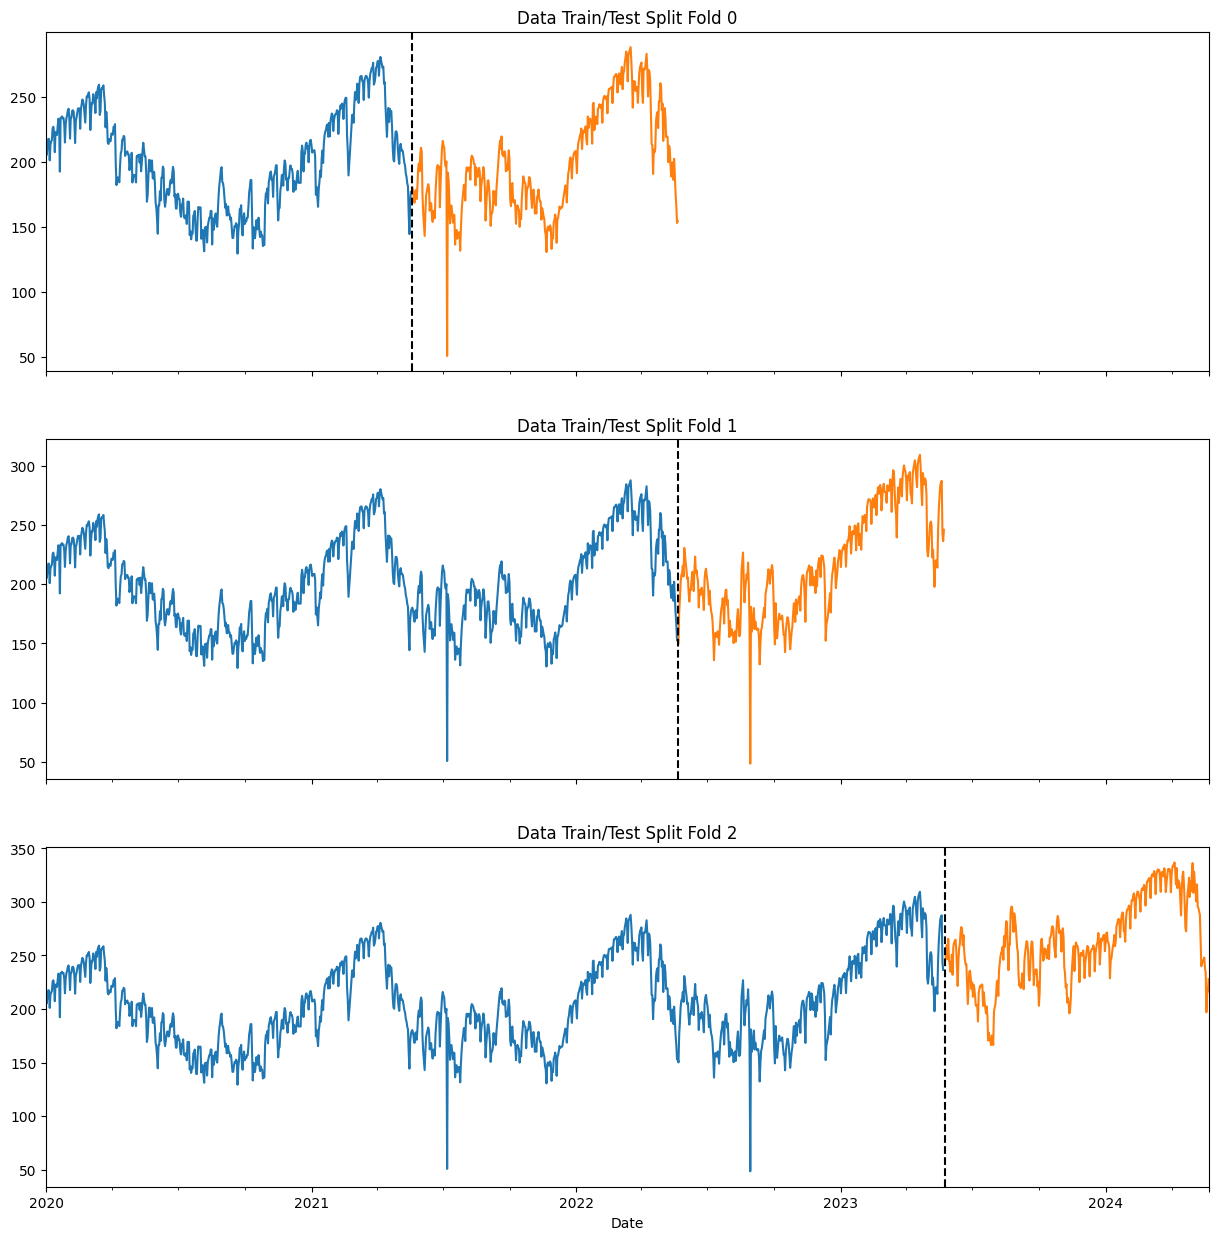

In [27]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train[state].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test[state].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [28]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [29]:
df

,Karnataka,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2020-01-01,212.2,2,1,1,2020,1,1,1
2020-01-02,205.3,3,1,1,2020,2,2,1
2020-01-03,212.4,4,1,1,2020,3,3,1
2020-01-04,217.5,5,1,1,2020,4,4,1
2020-01-05,217.4,6,1,1,2020,5,5,1
...,...,...,...,...,...,...,...,...
2024-05-18,233.6,5,2,5,2024,139,18,20
2024-05-19,196.9,6,2,5,2024,140,19,20
2024-05-20,214.5,0,2,5,2024,141,20,21


In [30]:
def add_lags(df):
    target_map = df[state].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [31]:
df = add_lags(df)

In [32]:
df

,Karnataka,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Date,,,,,,,,,,,
2020-01-01,212.2,2,1,1,2020,1,1,1,NaN,NaN,NaN
2020-01-02,205.3,3,1,1,2020,2,2,1,NaN,NaN,NaN
2020-01-03,212.4,4,1,1,2020,3,3,1,NaN,NaN,NaN
2020-01-04,217.5,5,1,1,2020,4,4,1,NaN,NaN,NaN
2020-01-05,217.4,6,1,1,2020,5,5,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-18,233.6,5,2,5,2024,139,18,20,287.5,154.4,172.6
2024-05-19,196.9,6,2,5,2024,140,19,20,243.3,150.1,168.4
2024-05-20,214.5,0,2,5,2024,141,20,21,236.5,176.4,177.1


In [33]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <636BF463-1886-392D-B8B3-6011C44DCEE9> /Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


In [ ]:
tss = TimeSeriesSplit(n_splits=3, test_size=365*1, gap=1)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = state

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:202.03895	validation_1-rmse:201.56815
[100]	validation_0-rmse:76.18639	validation_1-rmse:82.75816
[200]	validation_0-rmse:30.95862	validation_1-rmse:41.68782
[300]	validation_0-rmse:15.99420	validation_1-rmse:29.32709


c:\Users\Ankita\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:160: UserWarning: [22:04:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[400]	validation_0-rmse:11.95200	validation_1-rmse:26.50645
[500]	validation_0-rmse:10.91341	validation_1-rmse:25.82967
[600]	validation_0-rmse:10.34117	validation_1-rmse:25.77416
[610]	validation_0-rmse:10.28281	validation_1-rmse:25.79334
[0]	validation_0-rmse:201.82687	validation_1-rmse:219.16846
[100]	validation_0-rmse:76.32886	validation_1-rmse:95.63149
[200]	validation_0-rmse:32.04616	validation_1-rmse:51.04718
[300]	validation_0-rmse:18.29446	validation_1-rmse:36.43502


c:\Users\Ankita\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:160: UserWarning: [22:04:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[400]	validation_0-rmse:14.71100	validation_1-rmse:31.41013
[500]	validation_0-rmse:13.69291	validation_1-rmse:30.34542
[600]	validation_0-rmse:13.09399	validation_1-rmse:30.23829
[605]	validation_0-rmse:13.07204	validation_1-rmse:30.24451
[0]	validation_0-rmse:206.96740	validation_1-rmse:264.23372
[100]	validation_0-rmse:78.42346	validation_1-rmse:122.38614
[200]	validation_0-rmse:33.19726	validation_1-rmse:69.94272
[300]	validation_0-rmse:19.46114	validation_1-rmse:50.86931


c:\Users\Ankita\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:160: UserWarning: [22:04:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[400]	validation_0-rmse:16.17189	validation_1-rmse:44.11462
[500]	validation_0-rmse:15.17673	validation_1-rmse:42.14335
[600]	validation_0-rmse:14.62026	validation_1-rmse:41.38140
[700]	validation_0-rmse:14.17456	validation_1-rmse:41.01942
[800]	validation_0-rmse:13.81448	validation_1-rmse:40.98030
[826]	validation_0-rmse:13.74003	validation_1-rmse:41.01816


In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 32.2880
Fold scores:[25.73288361791037, 30.19024972602423, 40.940719545414034]


In [ ]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = state

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=600,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:221.23772
[100]	validation_0-rmse:83.72879
[200]	validation_0-rmse:35.43024
[300]	validation_0-rmse:20.87638
[400]	validation_0-rmse:17.16106


c:\Users\Ankita\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:160: UserWarning: [22:04:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[500]	validation_0-rmse:16.09094
[599]	validation_0-rmse:15.57633


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [ ]:
df.index.max()

Timestamp('2024-05-22 00:00:00')

In [ ]:
# Create future dataframe
future = pd.date_range('2024-05-23','2025-05-23', freq='D')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [ ]:
future_w_features = df_and_future.query('isFuture').copy()

In [ ]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

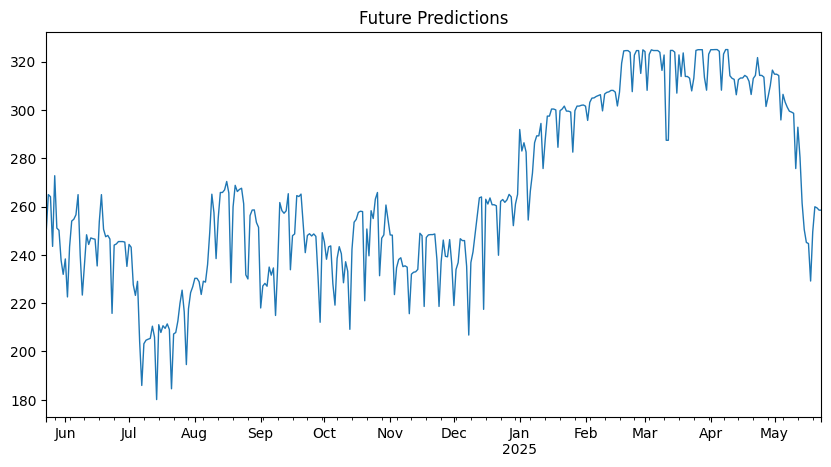

In [ ]:
future_w_features['pred'].plot(figsize=(10, 5),
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [ ]:
future_w_features

,Karnataka,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture,pred
2024-05-23,NaN,3,2,5,2024,144,23,21,245.8,207.9,180.7,True,249.915436
2024-05-24,NaN,4,2,5,2024,145,24,21,253.7,209.5,194.0,True,264.917786
2024-05-25,NaN,5,2,5,2024,146,25,21,259.8,215.8,198.6,True,264.059387
2024-05-26,NaN,6,2,5,2024,147,26,21,246.6,206.6,192.6,True,243.493729
2024-05-27,NaN,0,2,5,2024,148,27,22,265.6,230.8,205.9,True,272.752533
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-19,NaN,0,2,5,2025,139,19,21,214.5,236.5,176.4,True,249.468094
2025-05-20,NaN,1,2,5,2025,140,20,21,216.3,246.1,188.2,True,259.896912
2025-05-21,NaN,2,2,5,2025,141,21,21,227.9,242.8,201.9,True,259.434692
2025-05-22,NaN,3,2,5,2025,142,22,21,NaN,245.8,207.9,True,258.497589


In [ ]:
df.tail()

,Karnataka,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
Date,,,,,,,,,,,,
2024-05-18,233.6,5,2,5,2024,139,18,20,287.5,154.4,172.6,False
2024-05-19,196.9,6,2,5,2024,140,19,20,243.3,150.1,168.4,False
2024-05-20,214.5,0,2,5,2024,141,20,21,236.5,176.4,177.1,False
2024-05-21,216.3,1,2,5,2024,142,21,21,246.1,188.2,178.2,False
2024-05-22,227.9,2,2,5,2024,143,22,21,242.8,201.9,171.3,False


<AxesSubplot: xlabel='Date'>

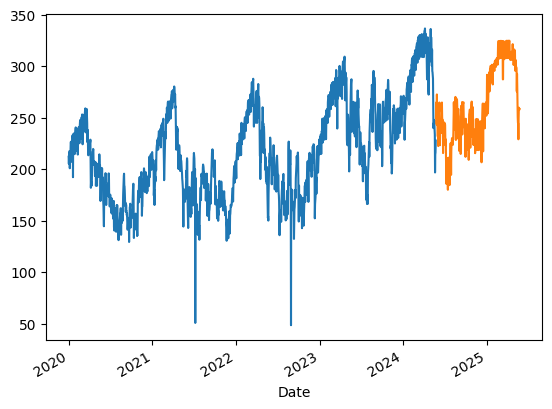

In [ ]:
df[state].plot()
future_w_features['pred'].plot()

In [ ]:
reg.save_model('xgb.json')

In [ ]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('xgb.json')


[0]	validation_0-rmse:8776.42868
[100]	validation_0-rmse:3459.16258
[200]	validation_0-rmse:1629.52341
[300]	validation_0-rmse:1088.90167


C:\Users\Ankita\AppData\Local\Temp\ipykernel_2036\2688385007.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  energy_met.fillna(method='ffill', inplace=True)
C:\Users\Ankita\AppData\Local\Temp\ipykernel_2036\2688385007.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  max_demand.fillna(method='ffill', inplace=True)
c:\Users\Ankita\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:160: UserWarning: [22:14:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[400]	validation_0-rmse:941.89459
[500]	validation_0-rmse:889.92982
[599]	validation_0-rmse:856.75264


<AxesSubplot: xlabel='Date'>

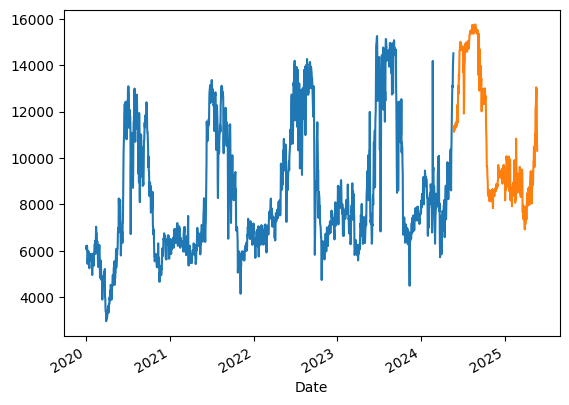

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb

energy_met=pd.read_csv('energy_states_consolidated.csv')
max_demand=pd.read_csv('max_states_consolidated.csv')

# Convert the 'Date' column to datetime format
energy_met['Date'] = pd.to_datetime(energy_met['Date'],format='%d-%m-%y')
max_demand['Date'] = pd.to_datetime(max_demand['Date'],format='%d-%m-%y')

#Setting the Date column as the index
energy_met.set_index('Date', inplace=True)
max_demand.set_index('Date', inplace=True)

energy_met.sort_index(inplace=True)
max_demand.sort_index(inplace=True)


# Handle missing values (e.g., forward fill)
energy_met.fillna(method='ffill', inplace=True)
max_demand.fillna(method='ffill', inplace=True)

state='Punjab'
df=pd.DataFrame(max_demand[state])

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

def add_lags(df):
    target_map = df[state].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

# Retrain on all data
df = create_features(df)
df = add_lags(df)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = state

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=600,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

# Create future dataframe
future = pd.date_range('2024-05-23','2025-05-23', freq='D')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

future_w_features = df_and_future.query('isFuture').copy()

future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

df[state].plot()
future_w_features['pred'].plot()